In [1]:
# @title Setup
# Prior to running, upload data_loader to /content/

In [2]:
# @title Imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod
from google.colab import drive
from data_loader import DataLoader

In [3]:
# @title Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# @title Load Dataset

FILE_PATH_TRAIN = "/content/drive/MyDrive/academics/gwu/2024-2025/spring/CSCI 4366/data/dataset_1a_train.h5"
FILE_PATH_VAL = "/content/drive/MyDrive/academics/gwu/2024-2025/spring/CSCI 4366/data/dataset_1a_val.h5"
FILE_PATH_TEST = "/content/drive/MyDrive/academics/gwu/2024-2025/spring/CSCI 4366/data/dataset_1a_test.h5"

dataloader = DataLoader(FILE_PATH_TRAIN)
dataloader.create_tf_dataset()
dataset_train = dataloader.get_dataset()

dataloader = DataLoader(FILE_PATH_VAL)
dataloader.create_tf_dataset()
dataset_val = dataloader.get_dataset()

dataloader = DataLoader(FILE_PATH_TEST)
dataloader.create_tf_dataset()
dataset_test = dataloader.get_dataset()

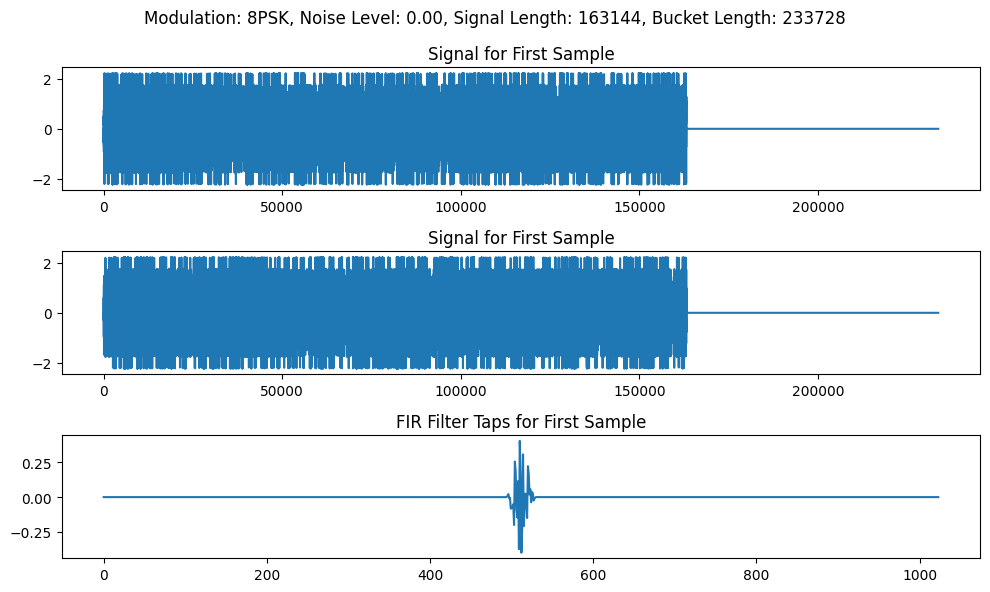

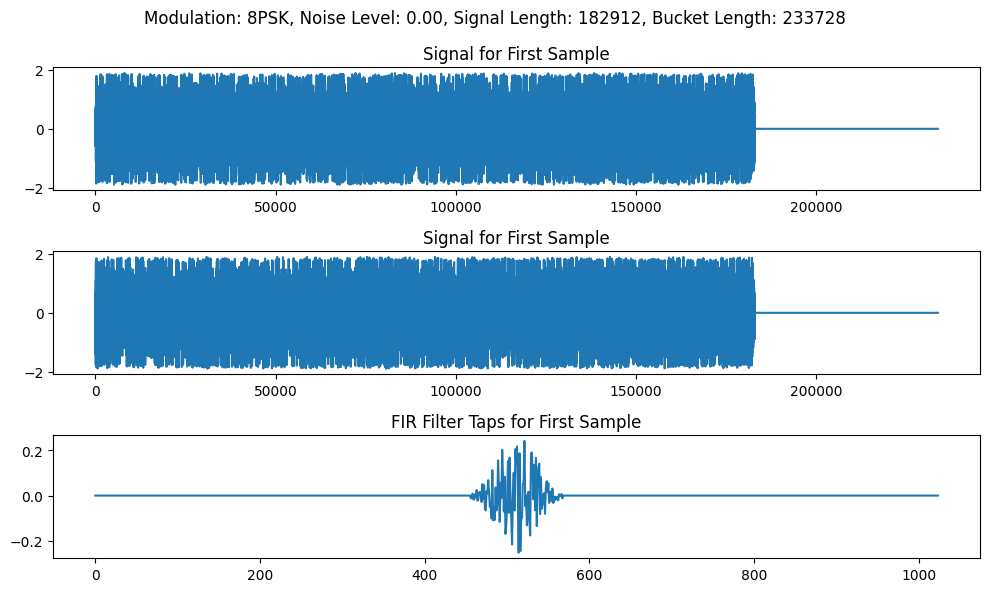

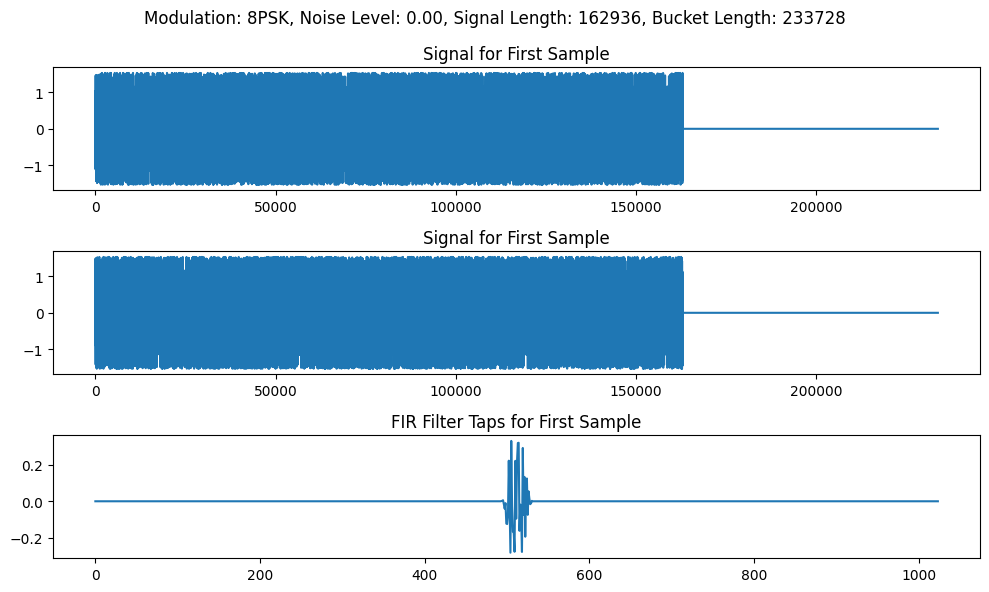

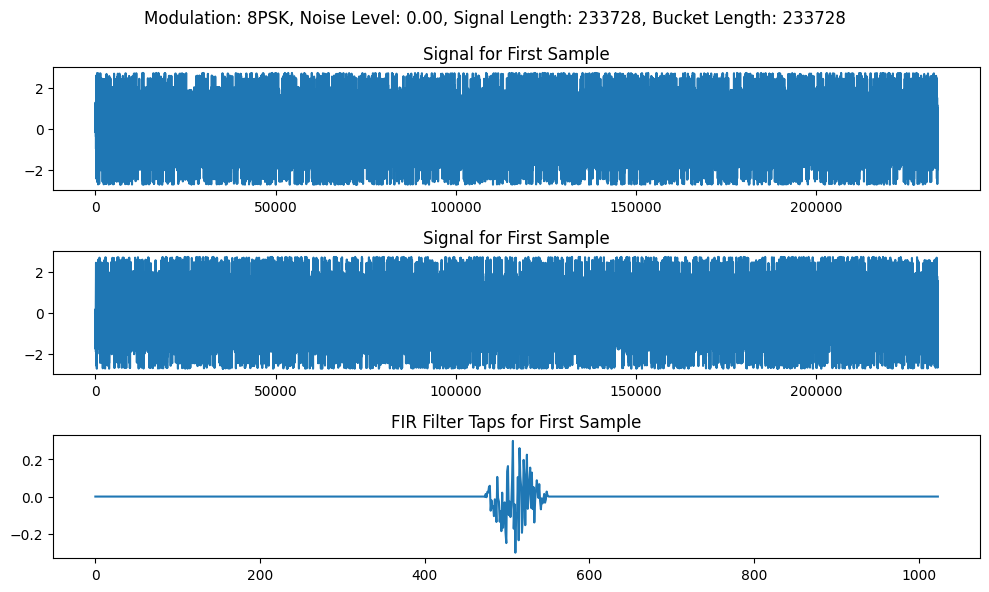

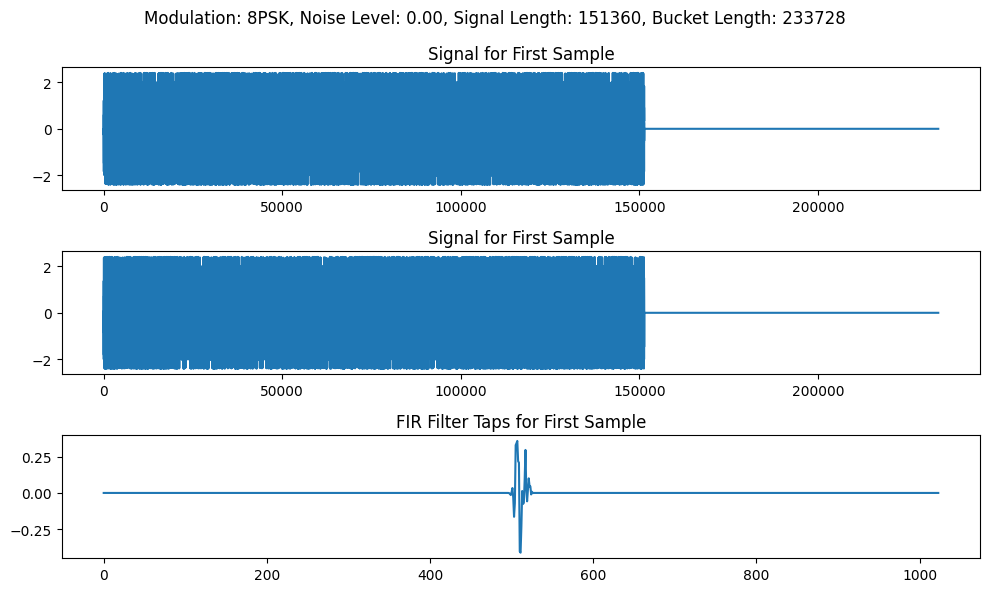

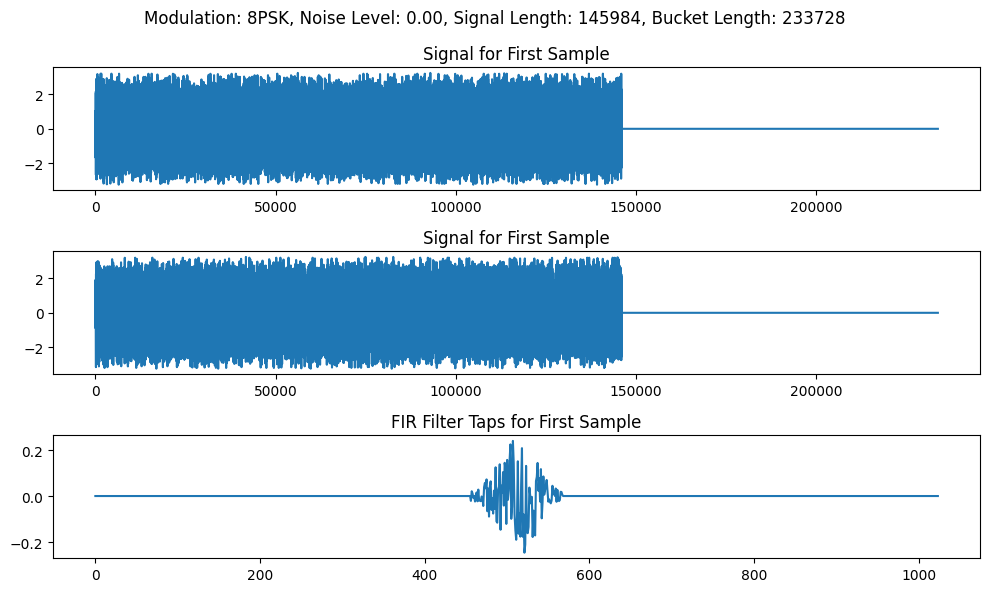

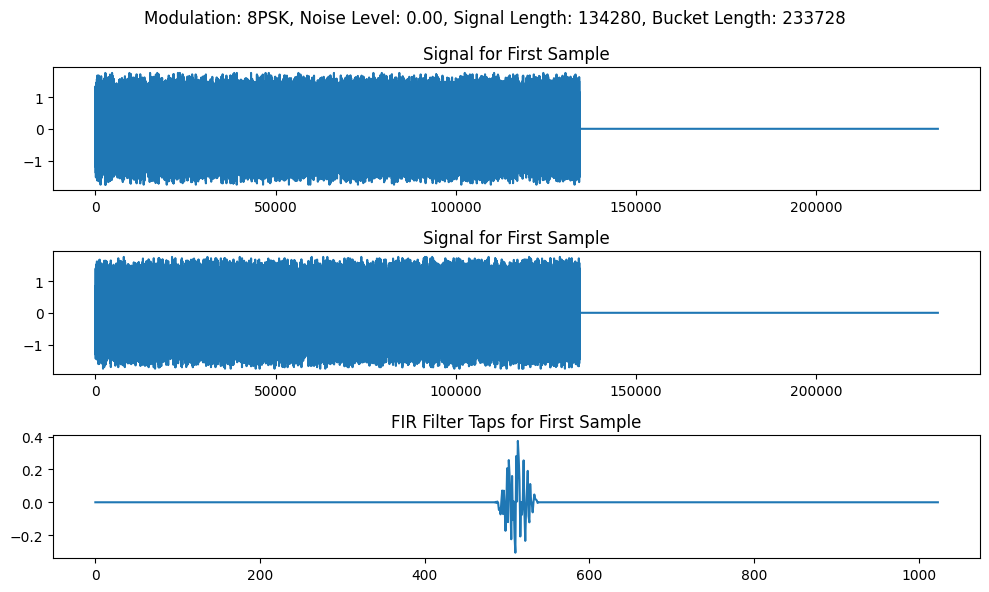

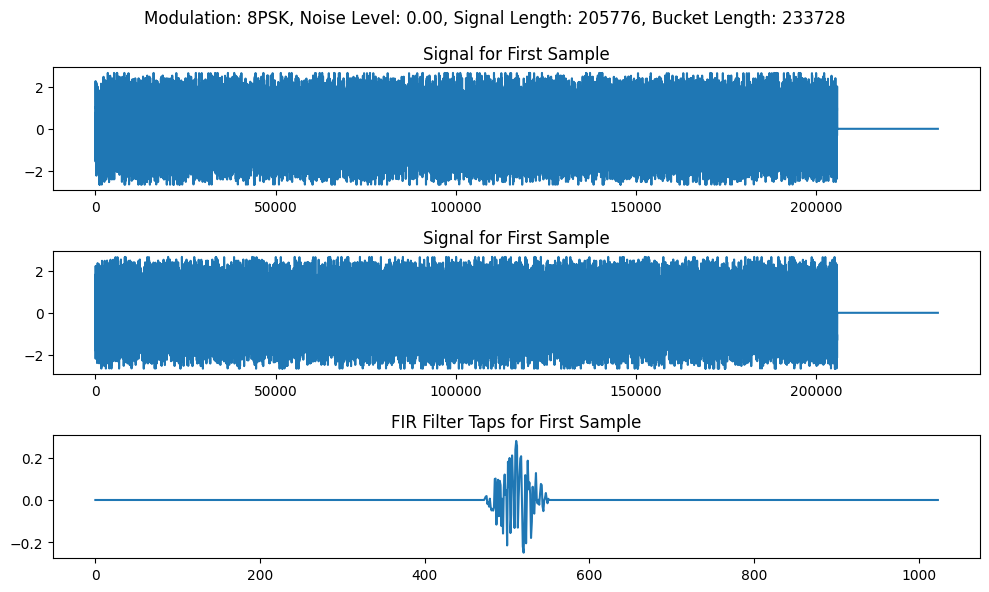

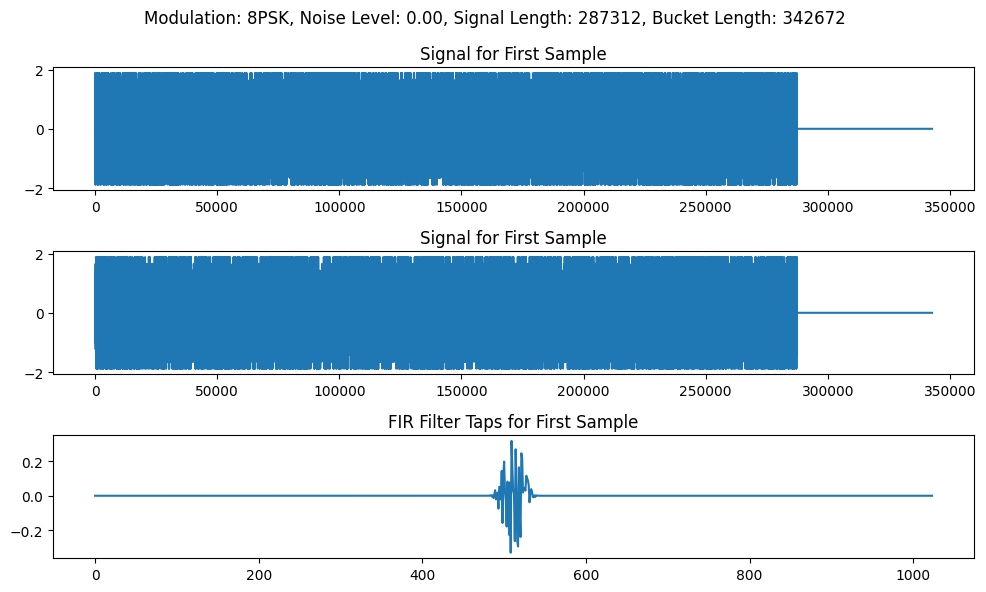

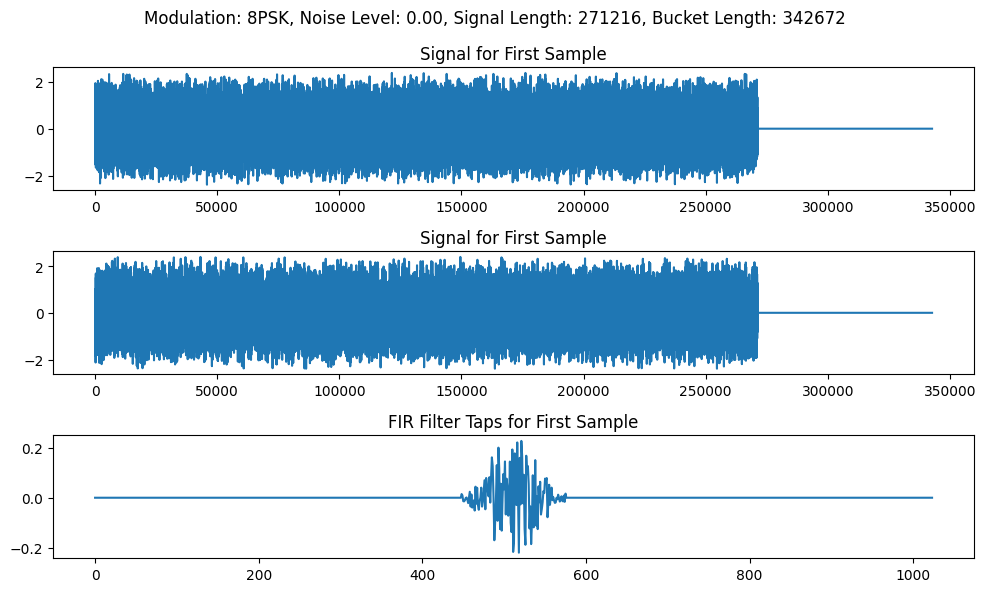

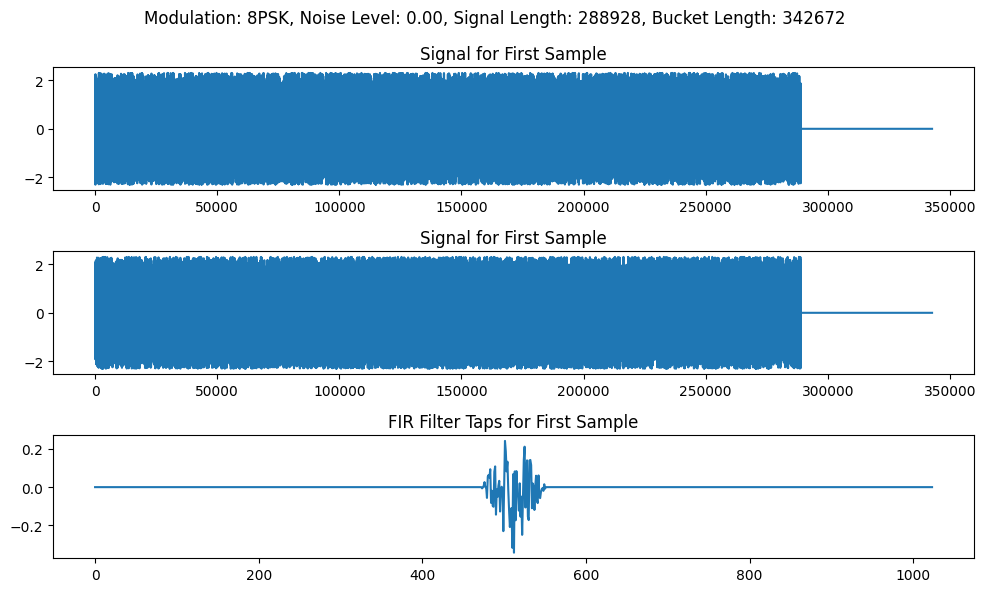

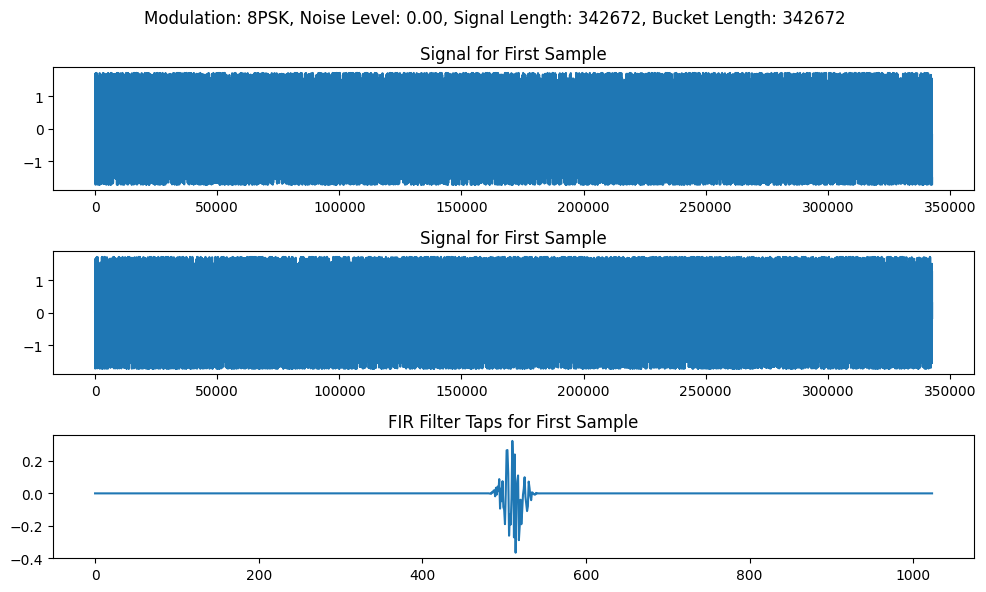

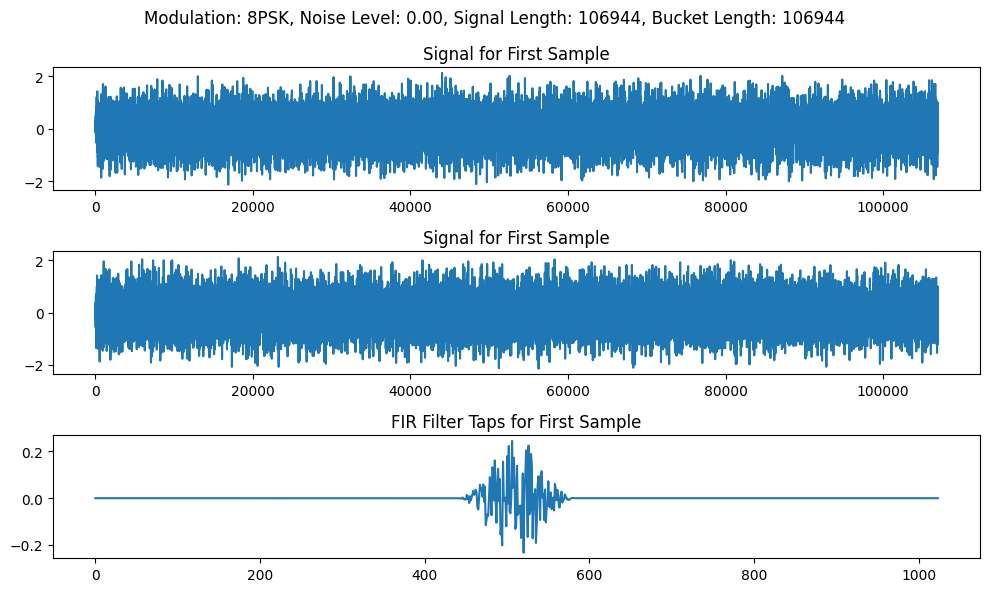

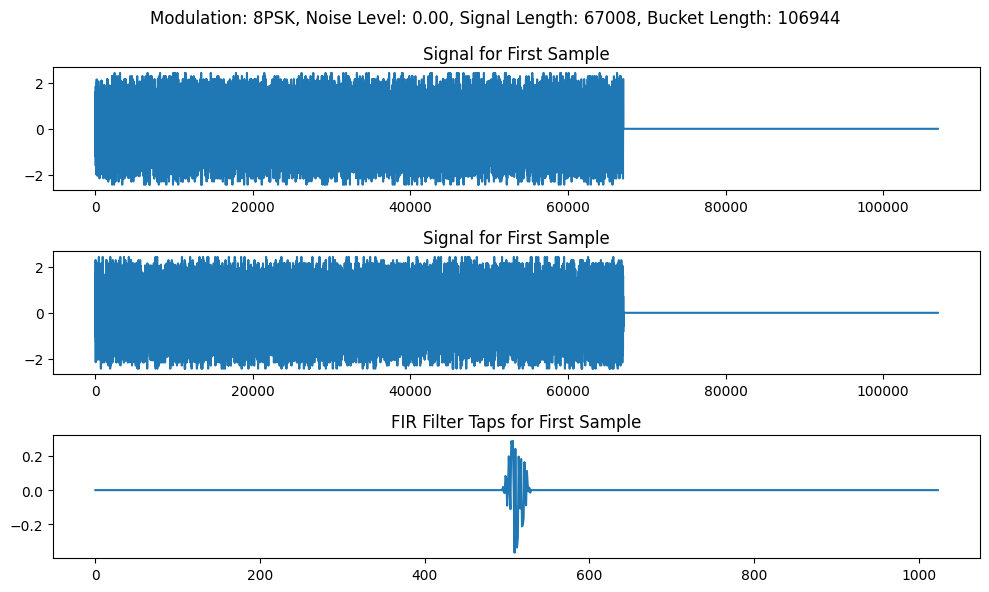

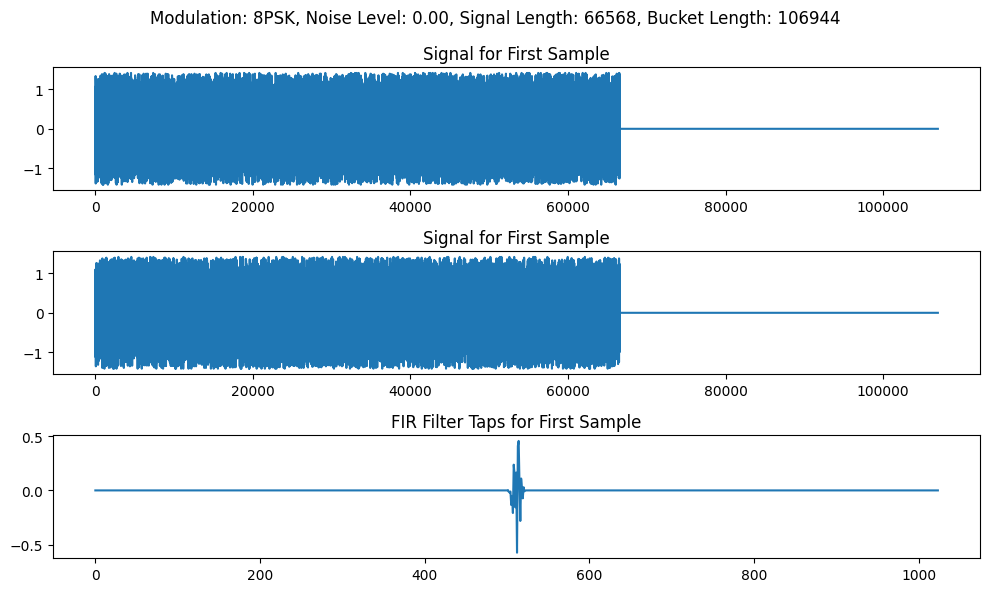

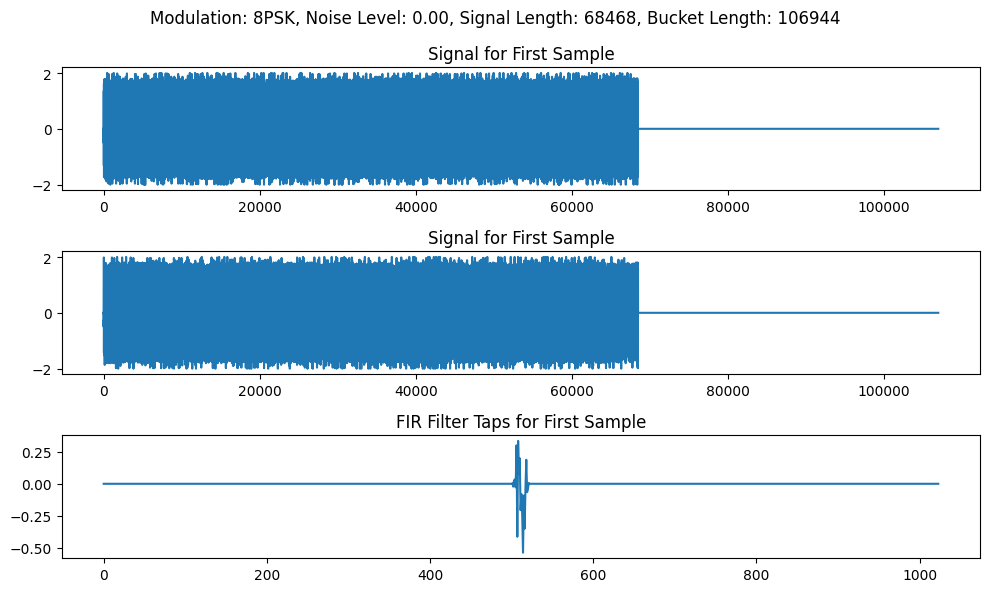

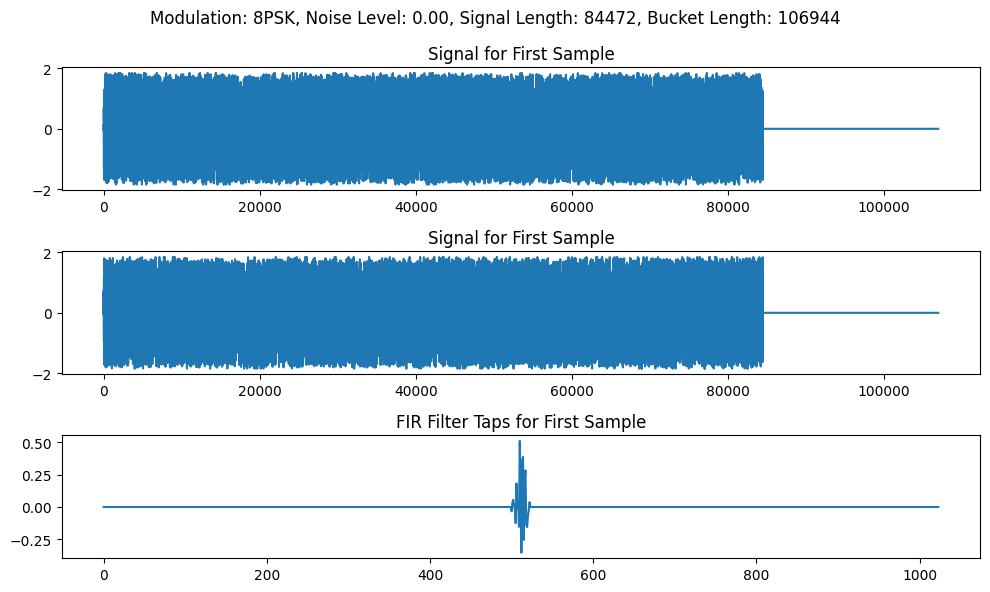

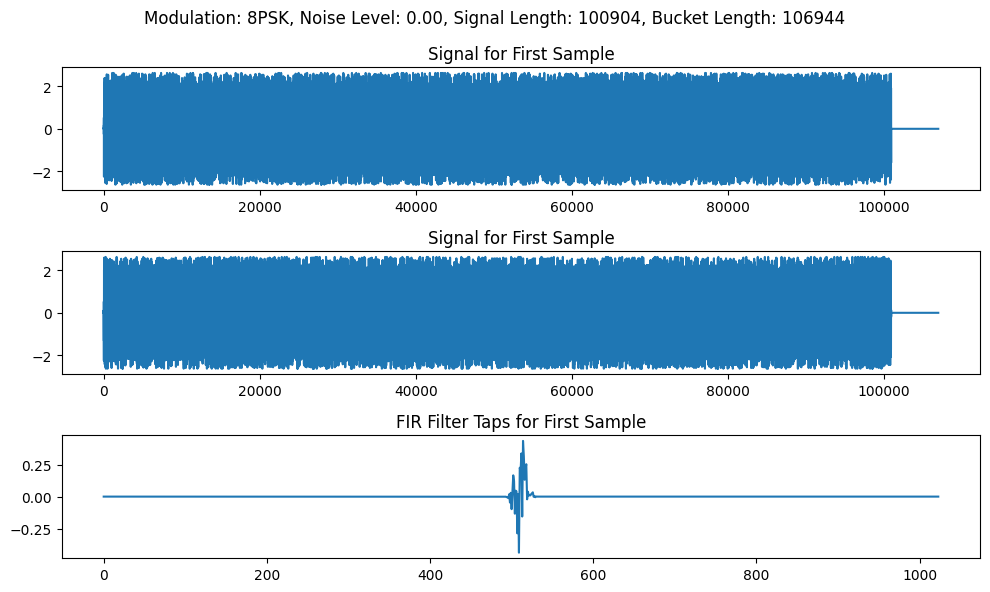

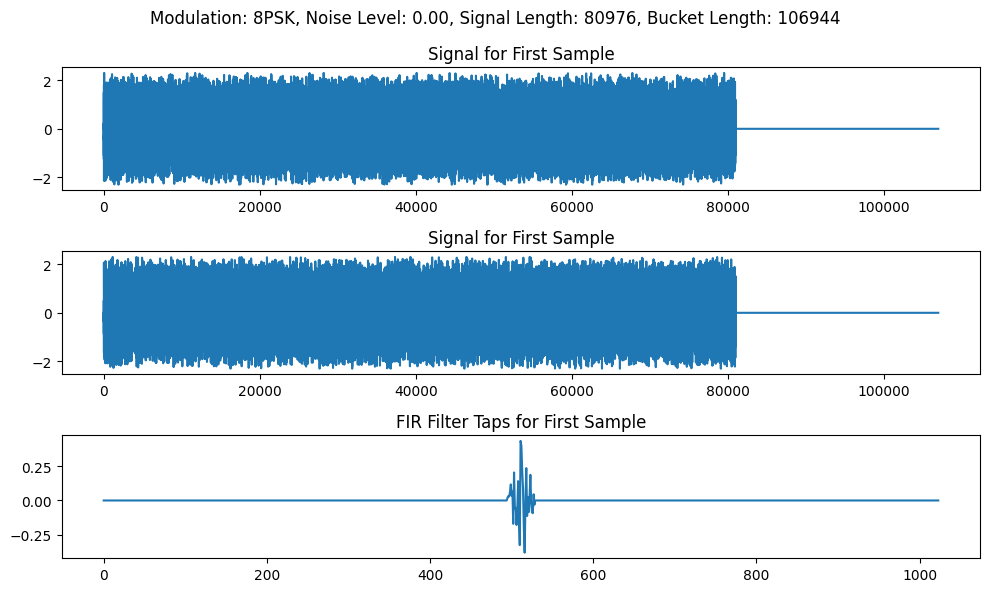

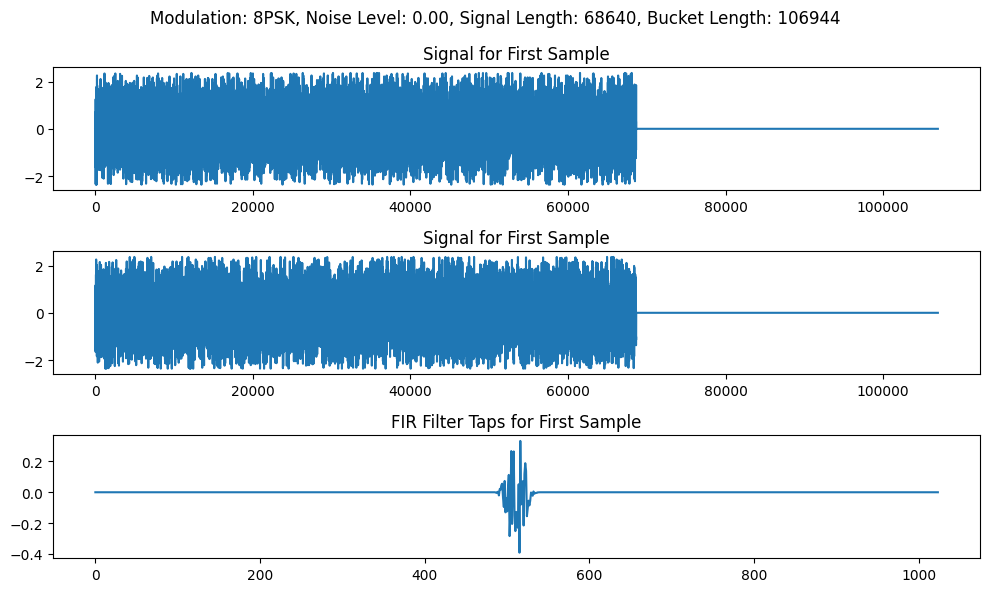

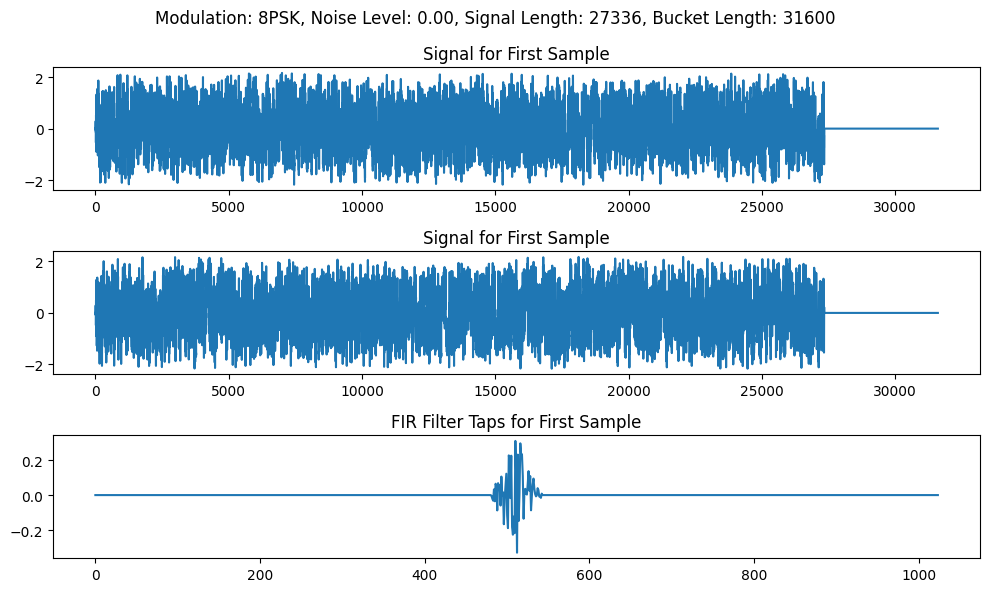

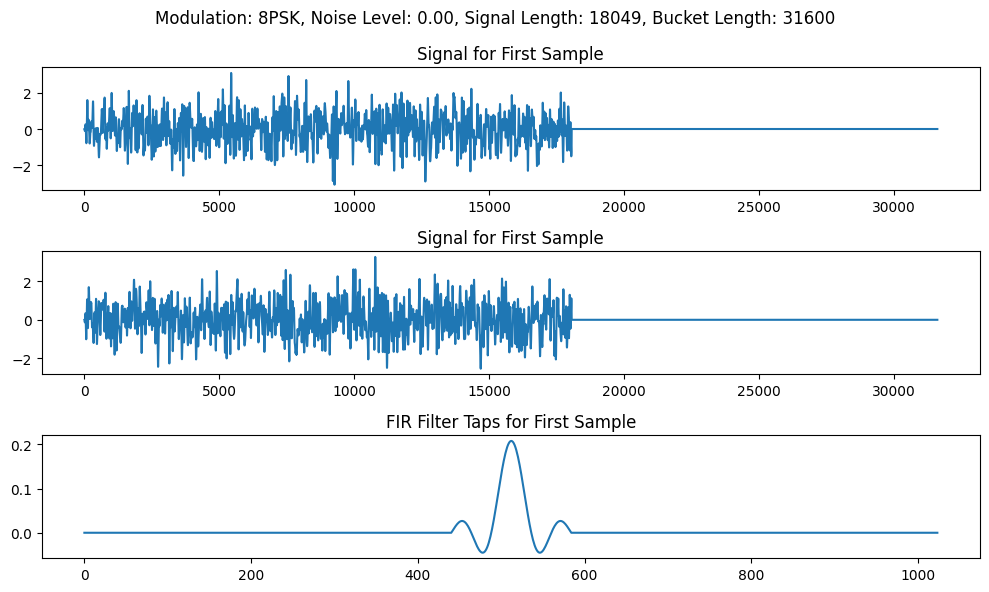

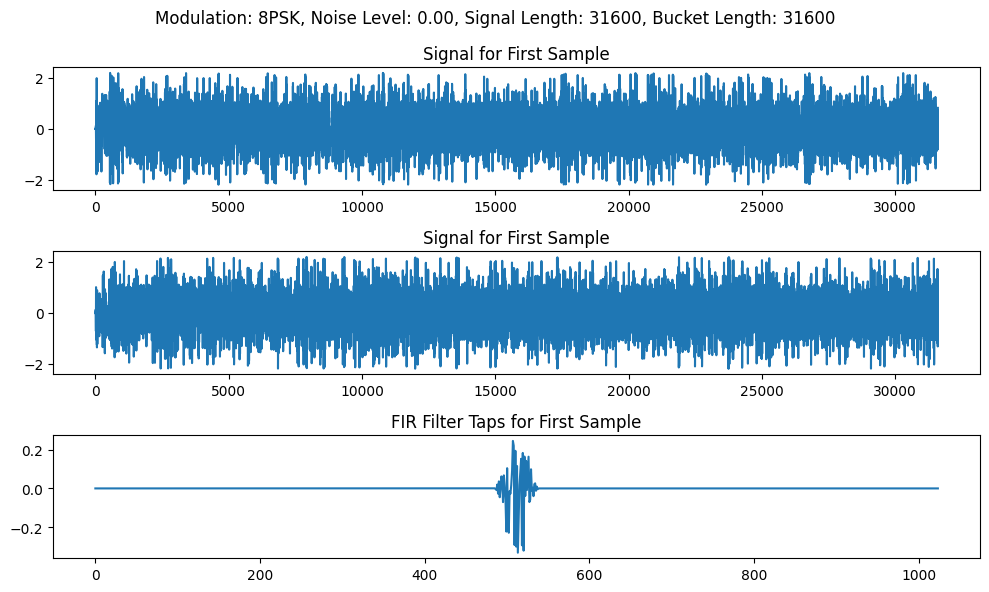

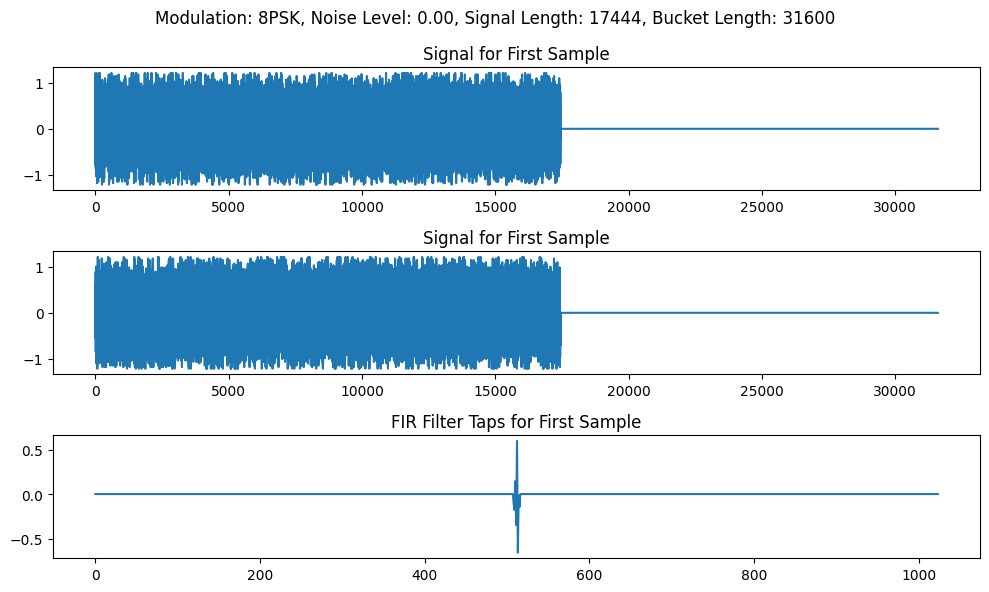

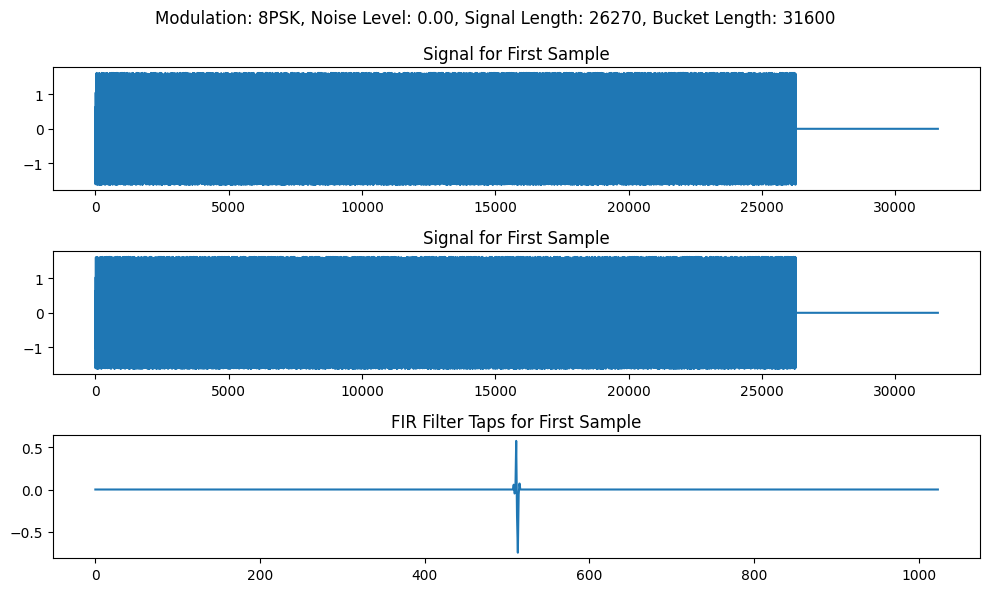

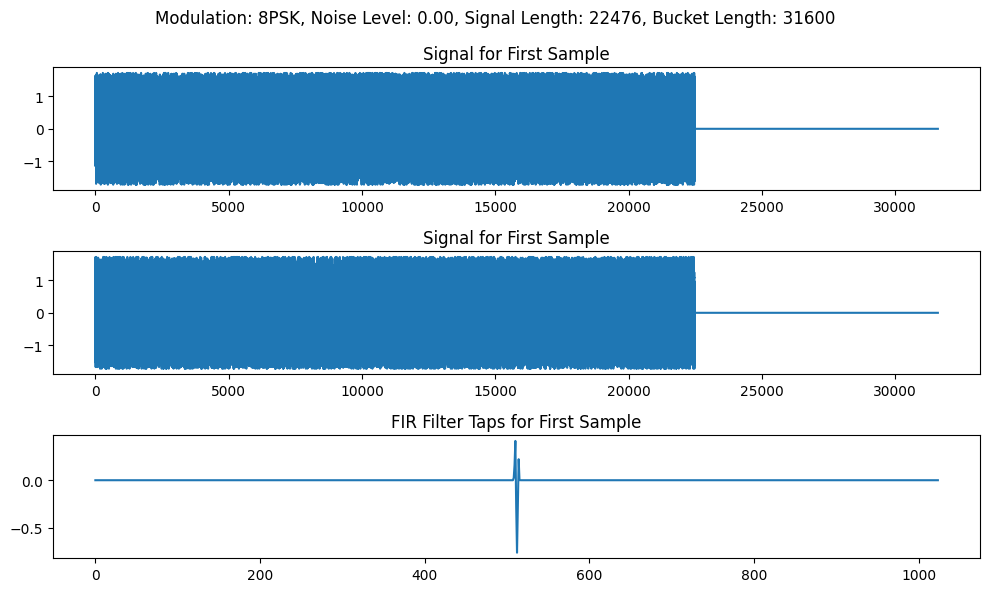

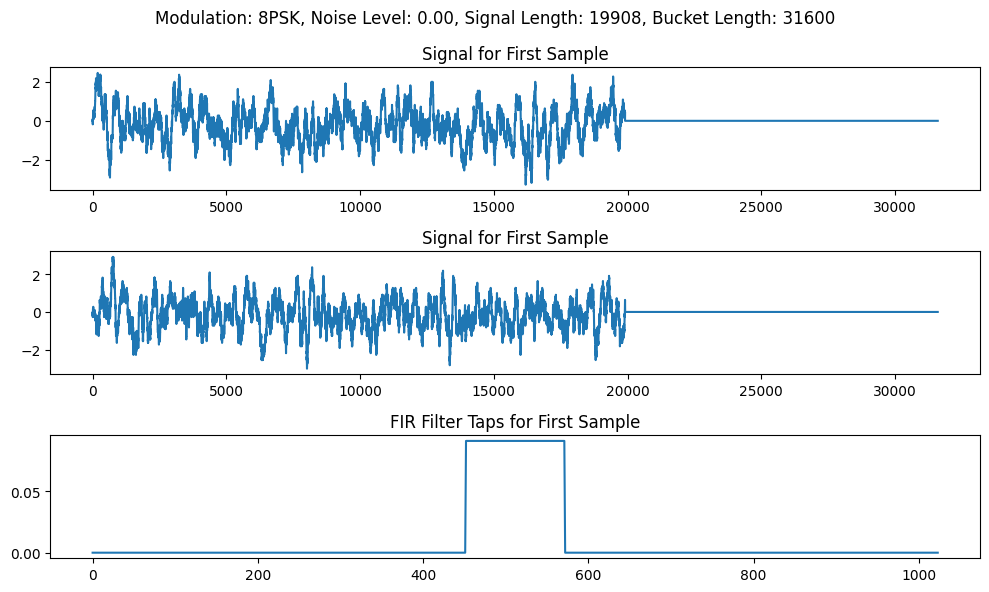

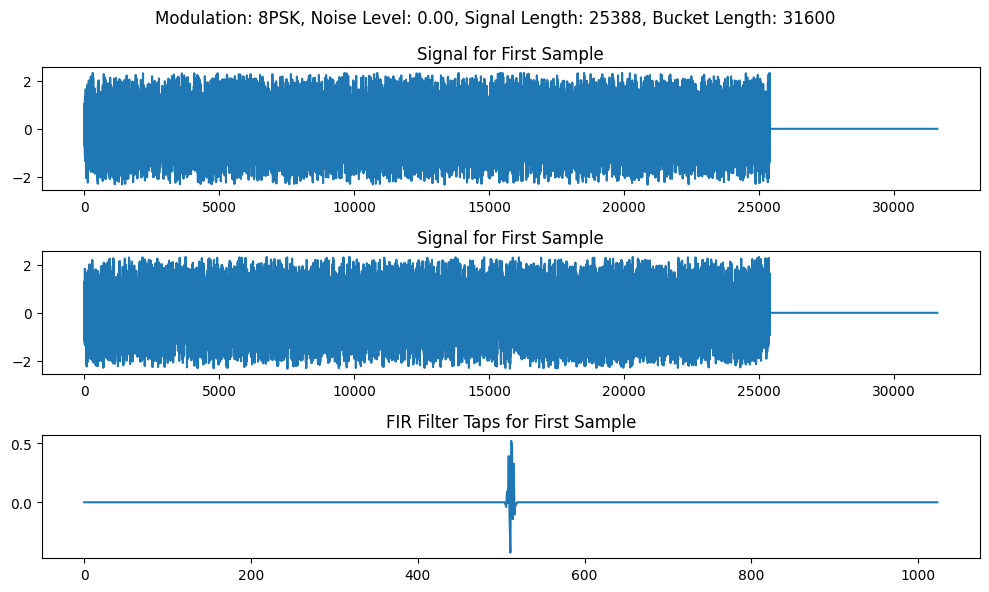

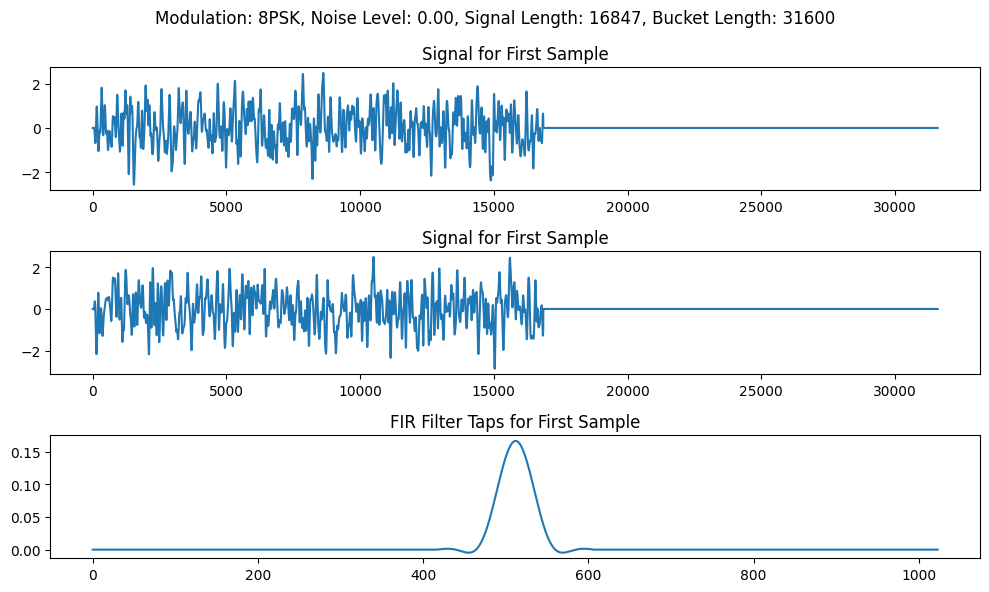

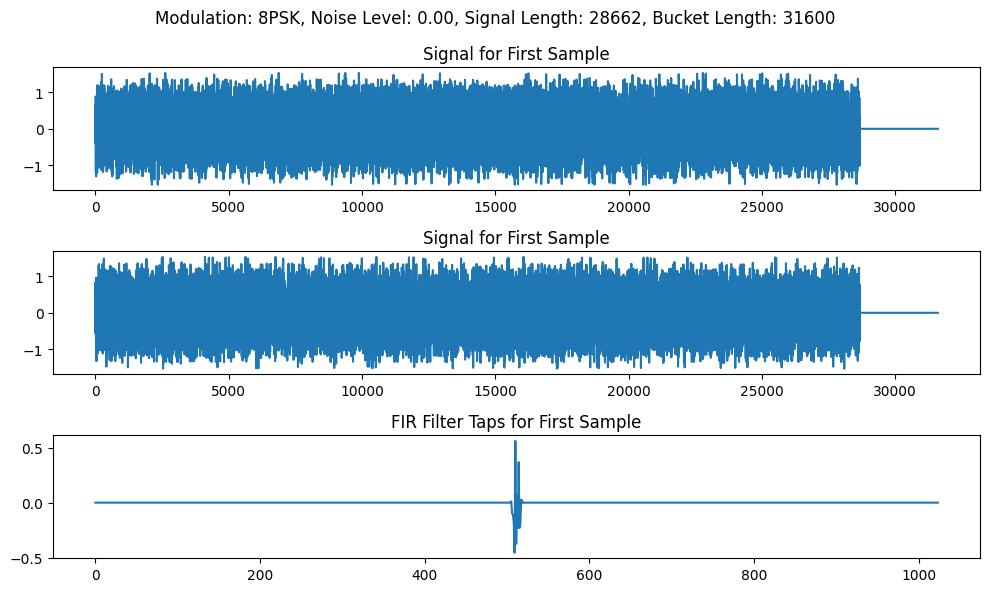

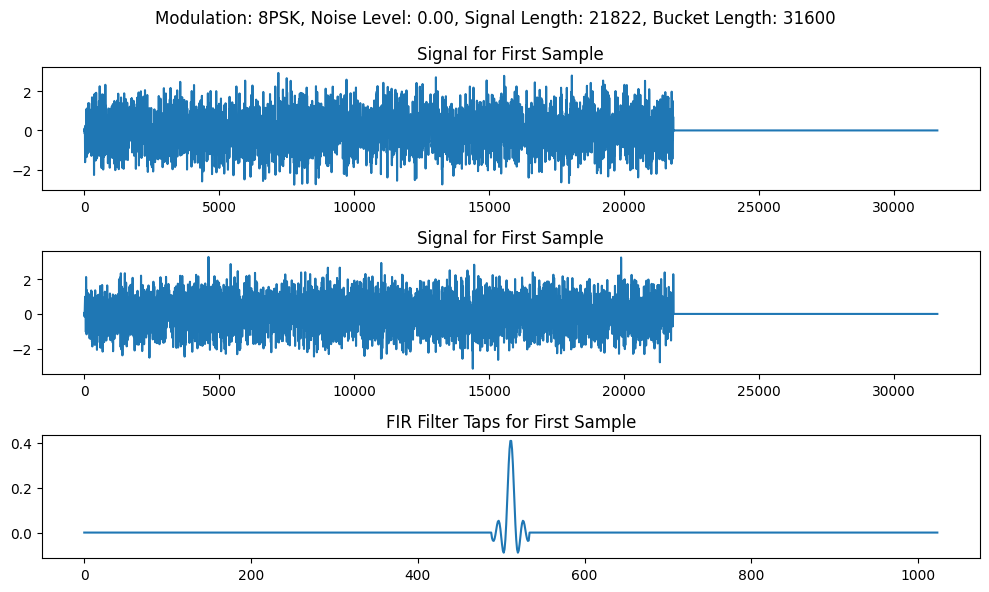

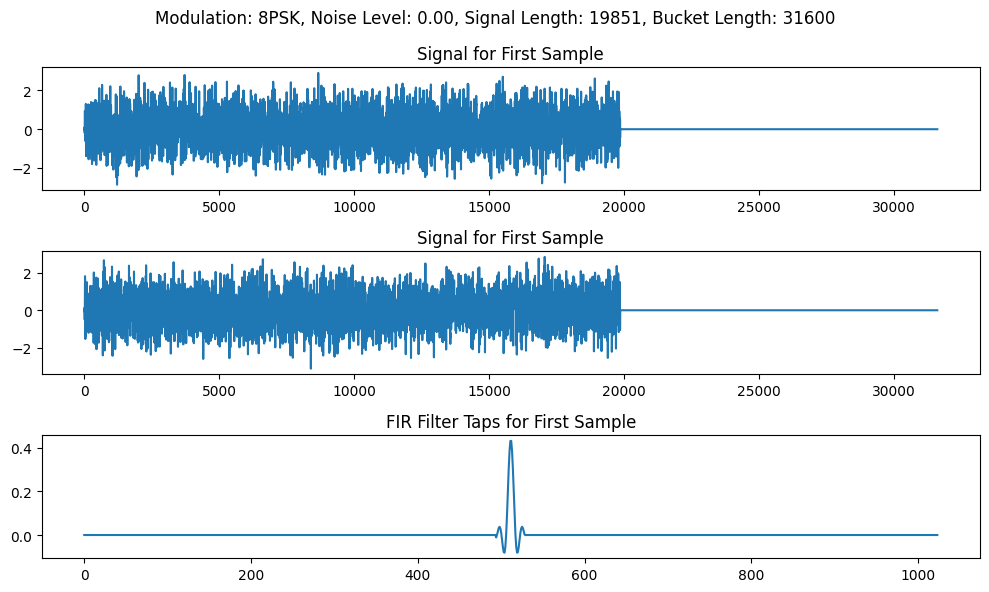

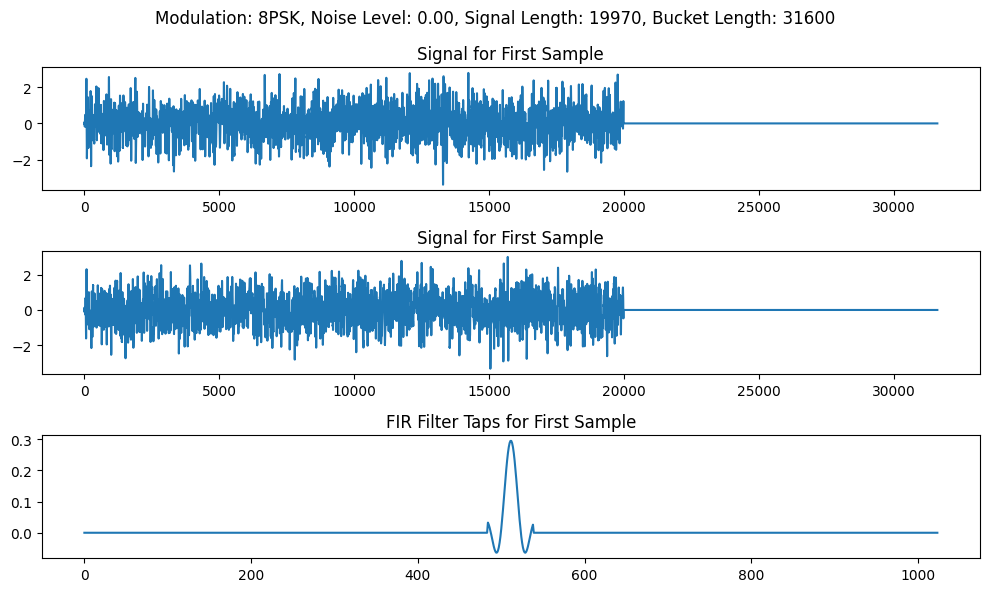

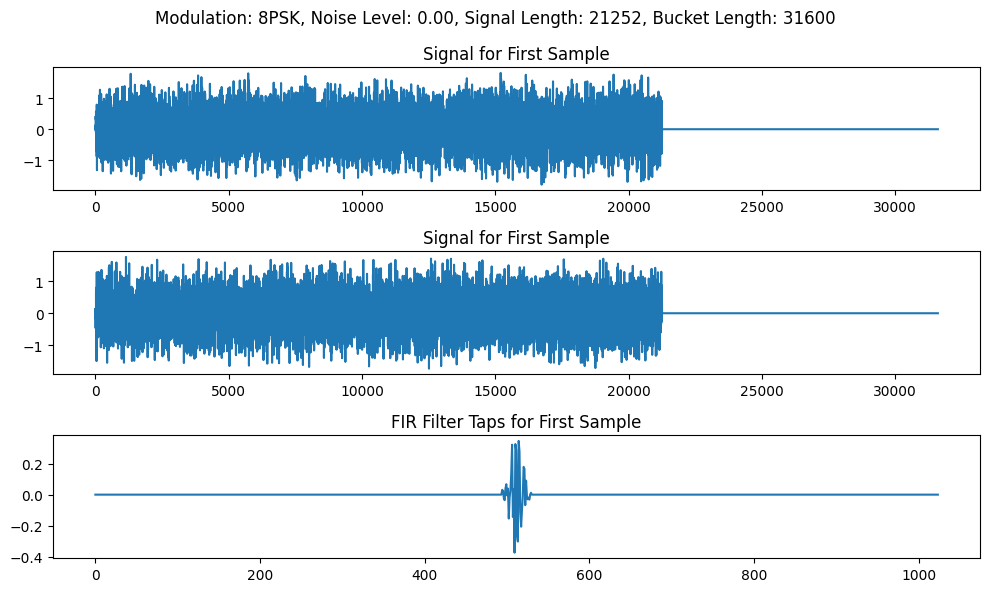

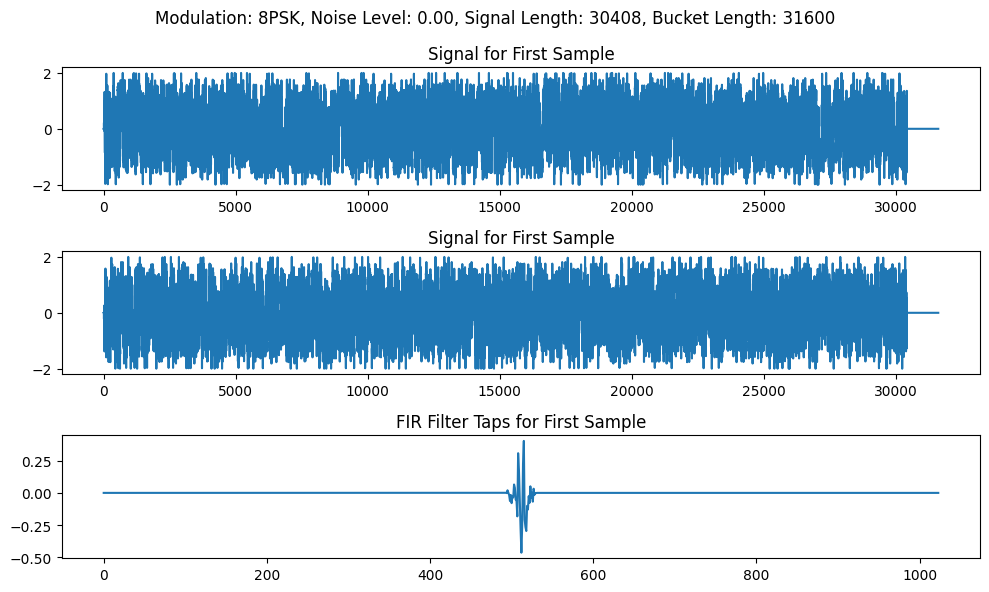

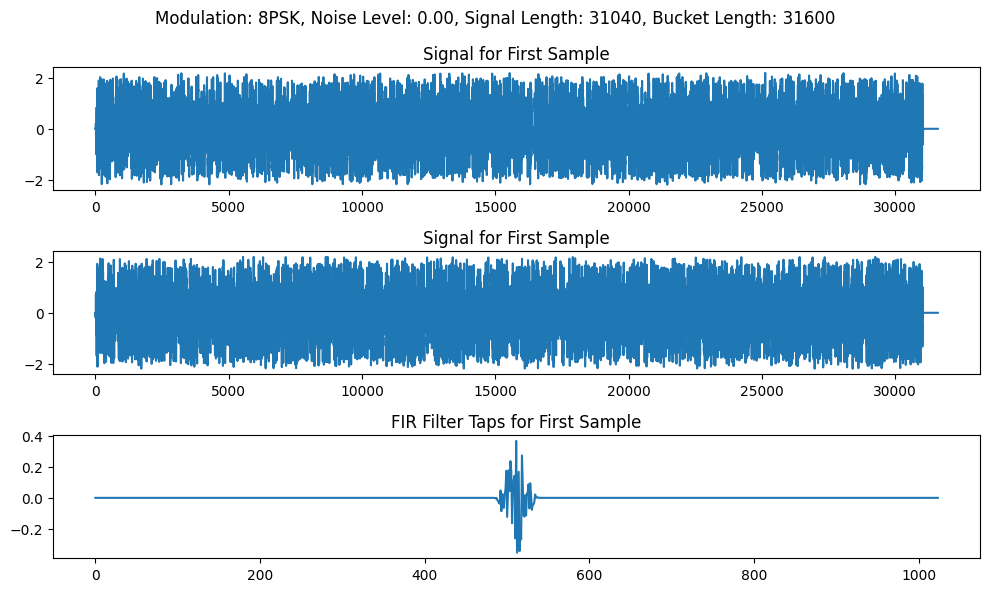

In [5]:
# @title Visualize Data
dataloader.plot_batch()

In [ ]:
# TODO:

# 1. preprocess range of inputs and outputs

In [ ]:
# @title PulseMatch 1D-CNN Class
class PulseMatchCNN(tf.keras.Model):
  def __init__(
      self,
      num_dense_layers: int=3,
      dense_layer_size: int=64,
      dropout: float=0.2,
      loss_lambda: float=0.5,
      padding_lambda: float=0.5
      ) -> None:
    super(PulseMatchCNN, self).__init__()

    # Model parameters
    self.num_dense_layers = num_dense_layers
    self.dense_layer_size = dense_layer_size
    self.dropout = dropout
    self.loss_lambda = loss_lambda
    self.padding_lambda = padding_lambda

    # Model
    self.model = self.make_model()

    # History
    self.history = {'loss': [], 'val_loss': []}

  # TODO: Function definition
  def make_model(self) -> tf.keras.Model:
    """Create PulseMatchCNN model"""
    inputs = tf.keras.Input(shape=(None, 2))
    x = tf.keras.layers.Conv1D(32, 3, activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.Conv1D(64, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    for _ in range(self.num_dense_layers):
        x = tf.keras.layers.Dense(self.dense_layer_size, activation='relu')(x)
        x = tf.keras.layers.Dropout(self.dropout)(x)

    outputs = tf.keras.layers.Dense(1024, activation='sigmoid')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

  # TODO: Function definition
  def call(self, inputs, training: bool=False):
    """Call PulseMatchCNN model"""
    return self.model(inputs=inputs, training=training)

  # TODO: Function definition
  def train_step(self, batch, optimizer):
    """Custom training step."""
    # Process batch
    signals, fir_filters, _, _, _, _, _, _, _, _, _, _ = batch

    with tf.GradientTape() as tape:
      predictions = self(signals, training=True)
      loss = self.compute_loss(fir_filters, predictions, batch)

    # Apply optimization
    gradients = tape.gradient(loss, self.trainable_variables)
    optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    # return loss
    return loss

  # TODO: Funnction definiton
  def test_step(self, batch):
    """Custom test step"""
    # Process batch
    signals, fir_filters, _, _, _, _, _, _, _, _, _, _ = batch

    predictions = self(signals, training=False)
    loss = self.compute_loss(fir_filters, predictions, batch)

    return loss

  # TODO: Function definition
  def fit(
      self,
      train_data,
      val_data,
      epochs,
      patience,
      optimizer
    ) -> None:
    """Custom Training loop for PulseMatchCNN"""
    # Patience setup
    best_val_loss = np.inf
    current_patience = patience

    # Loop through epochs
    for epoch in range(epochs):

      # Loop through training batches
      for batch in train_data:
        train_loss = self.train_step(batch, optimizer)
        self.history['loss'].append(train_loss)

      # Loop through validation batches
      for batch in val_data:
        val_loss = self.test_step(batch)
        self.history['val_loss'].append(val_loss)

      if epoch % 10 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

      if current_patience < 0:
        print("Early stopping triggered")
        print(f"Best validation loss: {best_val_loss}")
        break
      else:
        if val_loss < best_val_loss:
          best_val_loss = val_loss
          current_patience = patience
        else:
          current_patience -= 1

  # TODO: Function definition
  # TODO: Fix power computation
  def compute_power(self, filter_taps, signals):
    """Compute the power of a signal with optional masking."""
    return tf.reduce_sum(tf.square(signals), axis=-1)

  # TODO: Function definiton
  def compute_loss(self, y_true, y_pred, signals=None):
    # mask
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    inverse_mask = 1.0 - mask

    # Masked Power Ratio
    power_true = self.compute_power(y_true, signals)
    power_pred = self.compute_power(y_pred, signals)
    power_ratio_loss = tf.reduce_mean(tf.square(tf.abs(power_true / (power_pred + 1e-8) - 1)))

    # Masked MSE
    squared_diff = tf.square(y_true - y_pred) * mask
    mse_loss = tf.reduce_sum(squared_diff) / (tf.reduce_sum(mask) + 1e-8)

    # Penalize predictions in padding areas
    padding_penalty = tf.reduce_sum(tf.square(y_pred * inverse_mask))

    total_loss = (self.loss_lambda * power_ratio_loss) + \
                 ((1 - self.loss_lambda) * mse_loss) + \
                 (self.padding_lambda * padding_penalty)

    return total_loss

  # TODO: Function definition
  def predict(self, signals):
    """Predict using PulseMatchCNN"""
    return self.model.predict(signals)


  # TODO: Function definition
  def plot_loss(self):
    """Plots the loss curves of the model after training"""
    plt.plot(self.history['loss'], label='Training Loss')
    plt.plot(self.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

  # TODO: FUnction definition
  def save_model(self, path):
    """Save PulseMatchCNN model"""
    self.model.save(path)

In [ ]:
pulsematchCNN = PulseMatchCNN()

pulsematchCNN.fit(dataset_train, dataset_val, 100, 10, tf.keras.optimizers.Adam(learning_rate=0.001))

Epoch 0, Train Loss: 0.01821826584637165, Validation Loss: 0.009795794263482094
